In [8]:
from time import sleep
from selenium import webdriver
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import os, re, json

# 啟動瀏覽器工具
my_options = webdriver.ChromeOptions()
my_options.add_argument("--start-maximized") 
my_options.add_argument("--incognito")          
my_options.add_argument("--disable-popup-blocking") 
my_options.add_argument("--disable-notifications")


In [9]:
def searchLoca(location):
    global locaUrl
    # 點擊民宿&公寓選項
    homeBtn = driver.find_element(By.CSS_SELECTOR, 'li#tab-home').click()
    sleep(0.5)

    # 搜尋地點關鍵字
    locaInput = driver.find_element(By.CSS_SELECTOR, 'input#textInput'
    ).send_keys(location)
    sleep(0.5)

    # 隱藏搜尋推薦窗
    driver.execute_script("""
    var popup = document.getElementById('search-box-autocomplete-id');
    if (popup) {
        popup.style.display = 'none';
    }
    """)
    sleep(0.5)

    # 按下搜尋 => agoda 設定會跳出新分頁
    searchBtn = driver.find_element(By.CSS_SELECTOR, '#Tabs-Container > button'
    ).click()
    sleep(0.5)

    # 切換到新的分頁 => 取得目前的URL
    all_windows = driver.window_handles
    if len(all_windows) > 1:
        driver.switch_to.window(all_windows[-1]) 
    locaUrl = driver.current_url


In [10]:
def inputInfo(checkIn_Year, checkIn_Month, checkIn_Date, checkOut_Year, checkOut_Month, checkOut_Date, rooms = 1, adults = 2, children = 0):
    global locaUrl
    # 正則選擇並修改入住日、退房日、人數、房數
    # 可以是使用者輸入
    # 可以是廣泛爬取每一天看空房數量=> 明確得知淡旺季
    checkIn_Year = 1911 + checkIn_Year if checkIn_Year < 1911 else str(checkIn_Year)
    checkIn_Month = '0' + str(checkIn_Month) if checkIn_Month < 10 else str(checkIn_Month)
    checkIn_Date = '0' + str(checkIn_Date + 1) if (checkIn_Date + 1) < 10 else str(checkIn_Date + 1)

    checkOut_Year = 1911 + checkOut_Year if checkOut_Year < 1911 else str(checkOut_Year)
    checkOut_Month = '0' + str(checkOut_Month) if checkOut_Month < 10 else str(checkOut_Month)
    checkOut_Date = '0' + str(checkOut_Date + 1) if (checkOut_Date + 1) < 10 else str(checkOut_Date + 1)

    inputInfo = f"checkIn={checkIn_Year}-{checkIn_Month}-{checkIn_Date}&checkOut={checkOut_Year}-{checkOut_Month}-{checkOut_Date}&rooms={rooms}&adults={adults}&children={children}"
    reUrl = r"checkIn=(\d{4})-(\d{2})-(\d{2})&checkOut=(\d{4})-(\d{2})-(\d{2})&rooms=(\d{1,2})&adults=(\d{1,2})&children=(\d{1,2})"

    targetUrl = re.sub(reUrl, inputInfo, locaUrl)
    driver.get(targetUrl)

In [11]:

def scrollPage():
    count = 0
    limit = 3
    innerHeight = 0
    offset = 0
    while count <= limit:

        # 拿到可滾動高度
        offset = driver.execute_script(
            'return document.documentElement.scrollHeight;'
        )
        # 卷軸滾指定距離
        driver.execute_script(f'''
            window.scrollBy({{
                top: 1000,
                behavior: 'smooth'
            }});
            ''')
        sleep(2)

        # 取得捲動後的當前總高度
        innerHeight = driver.execute_script(
            'return document.documentElement.scrollHeight;'
        )

        # 確定還有沒有東西可以加載
        if offset == innerHeight:
            count += 1

In [12]:
def parse():
    global i
    # 尋找列表每一個資料
    hotelItems = 'ol.hotel-list-container li[data-selenium="hotel-item"]'
    elements = driver.find_elements(By.CSS_SELECTOR, hotelItems)

    # 再取每一個區塊裡的連結
    for elm in elements:
        # 取得名宿名稱
        name = elm.find_element(
            By.CSS_SELECTOR,
            'h3[data-selenium="hotel-name"]'
        )
        hotelName = name.get_attribute('innerHTML')

        # 取得民宿連結
        a = elm.find_element(
            By.CSS_SELECTOR,
            'a.PropertyCard__Link'
        )
        h_url = a.get_attribute('href')
        hotelUrl = h_url.split('.html?')[0] + '.html'

        # 取得名宿地點
        label = elm.find_element(
            By.CSS_SELECTOR,
            'button[data-selenium="area-city-text"] > span'
        )
        hotelLocation = label.get_attribute('label')

        # 分離出鄉鎮、縣市、距市中心距離
        hotelTown = hotelLocation.split(',')[0]
        hotelCity = hotelLocation.split(',')[1].split('-')[0].strip()
        distSentence = hotelLocation.split(',')[1].split('-')[1].strip()
        match = re.search(r"(\d+(\.\d+)?)", distSentence)

        if match:
            centralDist = match.group(1)
        else:
            centralDist = 0

        # 取得價錢
        try:
            money = elm.find_element(
                By.CSS_SELECTOR,
                'span.PropertyCardPrice__Value'
            )
            hotelPrice = money.get_attribute('innerHTML')

        except NoSuchElementException:
            hotelPrice = None

        #丟到 list
        listData.append({
            'name': hotelName,
            'link': hotelUrl,
            'City': hotelCity,
            'Town': hotelTown,
            'Distance_from_Central': centralDist, 
            'price': hotelPrice
        })
        i += 1
        print(f'{i}. 已寫入 {hotelName}')

In [13]:

def saveJson():
    os.makedirs('agoda', exist_ok=True) 
    with open(f'./agoda/houselist.json', "w", encoding = "utf-8") as file:
        file.write(
            json.dumps(listData, ensure_ascii=False, indent=4)
        )

In [14]:
locaUrl = ''
listData = []
listData.clear()
i = 0

driver = webdriver.Chrome(options = my_options)
url = 'https://www.agoda.com/'
driver.get(url)

searchLoca('宜蘭')
inputInfo(2025, 9, 5, 2025, 9, 6, 1, 10, 0)
sleep(2)
while True:
    scrollPage()
    sleep(2)
    parse()
    try:
        nextpageBtn = driver.find_element(By.CSS_SELECTOR, 'button#paginationNext').click()
    except (NoSuchElementException, TimeoutException):
        saveJson()
        print('完成爬取資料，已寫入檔案！')
        break
    else:
        sleep(2)



1. 已寫入 古舍古鄉 (Old House Homestay)
2. 已寫入 天送幸福和苑 (Tian Song Villa)
3. 已寫入 沃客宅 (Walk in house)
4. 已寫入 湯記溫泉民宿 (Tom Gi Hotspring B&amp;B)
5. 已寫入 蘇澳鎮的4臥室獨棟住宅 - 117平方公尺/5間專用衛浴 (JIURI)
6. 已寫入 羅東沐石
7. 已寫入 海邊民宿 (Hibnb Guesthouse)
8. 已寫入 羅東夜市幸福故事民宿II (Happiness Yes Hostel II)
9. 已寫入 頭城鎮的4臥室獨棟住宅 - 430平方公尺/4間專用衛浴 (Santorini beach home)
10. 已寫入 冬杉荷民宿 (Dong Shan He B&amp;B)
11. 已寫入 三星鄉的3臥室獨棟住宅 - 平方公尺/3間專用衛浴 (幸福三顆星-親子包棟民宿)
12. 已寫入 宜蘭頭城空空如也Kong Kong
13. 已寫入 宜蘭烏石驛站民宿
14. 已寫入 山杉青旅 (Sasa Youth Hostel)
15. 已寫入 嵐峰宿（全新包棟14人） (Lan Feng Su B&amp;B)
16. 已寫入 禾畔の民宿-近冬山河童玩節-ktv烤肉包棟
17. 已寫入 Child Busy
18. 已寫入 嗨斑馬輕旅行 (Hi Zebra Travel B&amp;B)
19. 已寫入 宜蘭市的4臥室別墅 - 平方公尺/5間專用衛浴 (Yongxin Homestay)
20. 已寫入 晟品溫泉湯旅 宜蘭縣058號
21. 已寫入 123會館 (123 Hall)
22. 已寫入 日出稻荷 (Sunrise Inari B&amp;B)
23. 已寫入 甜蜜的家包棟民宿
24. 已寫入 Onsense Villa
25. 已寫入 九塘苑 (9 Tan Yuan Homestay)
26. 已寫入 H-House 10-20人包棟 包廂式KTV 電動麻將 戶外烤肉區 寵物友善 生日party
27. 已寫入 丸山村民宿可歌將烤
28. 已寫入 沐築民宿 (Muzhu B&amp;B)
29. 已寫入 漫步香榭包棟民宿
30. 已寫入 微醺蝸牛 (Tipsy Snail)
31. 已寫入 旅居Villa
32. 已寫入 

In [15]:
# 轉成 DataFrame
df = pd.DataFrame(listData)

# 處理 None 和字串中的逗號
df['price'] = df['price'].str.replace(',', '')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Distance_from_Central 轉為 float
df['Distance_from_Central'] = pd.to_numeric(df['Distance_from_Central'], errors='coerce')

df.head(5)

,name,link,City,Town,Distance_from_Central,price
0,古舍古鄉 (Old House Homestay),https://www.agoda.com/zh-tw/old-house-homestay...,宜蘭縣,大同鄉,19.0,NaN
1,天送幸福和苑 (Tian Song Villa),https://www.agoda.com/zh-tw/h58891100/hotel/yi...,宜蘭縣,三星鄉,14.2,NaN
2,沃客宅 (Walk in house),https://www.agoda.com/zh-tw/walk-in-house/hote...,宜蘭縣,員山鄉,8.8,NaN
3,湯記溫泉民宿 (Tom Gi Hotspring B&amp;B),https://www.agoda.com/zh-tw/jc/hotel/yilan-tw....,宜蘭縣,礁溪鄉,15.4,NaN
4,蘇澳鎮的4臥室獨棟住宅 - 117平方公尺/5間專用衛浴 (JIURI),https://www.agoda.com/zh-tw/jiuri/hotel/yilan-...,宜蘭縣,蘇澳鎮,11.1,NaN


In [16]:
# 設定中文
plt.rcParams['font.sans-serif'] = ['Heiti TC', 'Microsoft JhengHei', 'SimHei', 'Arial Unicode MS']

# 數據整理
lower_bound = df['price'].quantile(0.05)
upper_bound = df['price'].quantile(0.95)
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

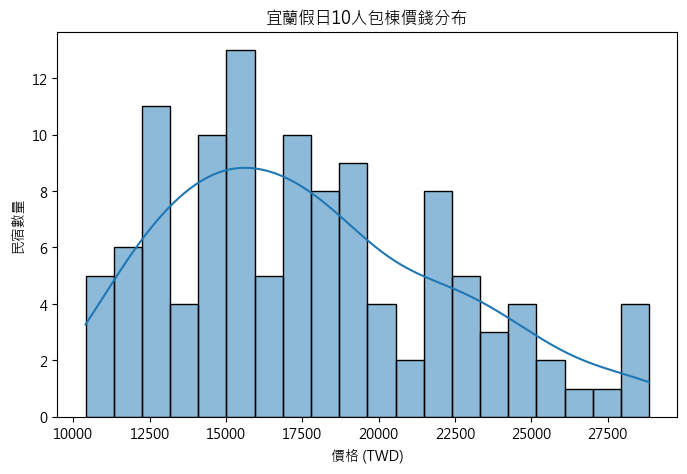

In [17]:
# 宜蘭包棟價錢分布（Histogram）
plt.figure(figsize=(8, 5))
sns.histplot(df_filtered['price'].dropna(), bins=20, kde=True)
plt.title('宜蘭假日10人包棟價錢分布')
plt.xlabel('價格 (TWD)')
plt.ylabel('民宿數量')
plt.show()

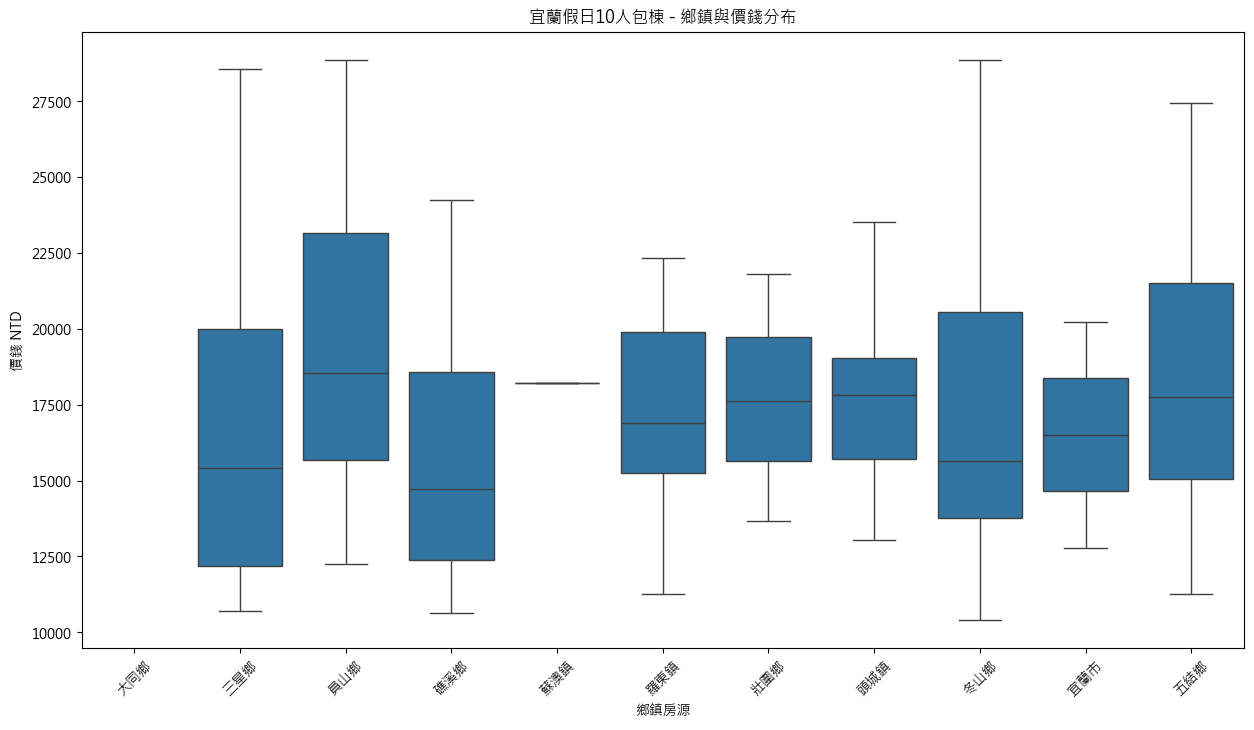

In [18]:
# 宜蘭鄉鎮與價錢分布（Box Plot）
plt.figure(figsize=(15, 8))
# 不畫離群值 
sns.boxplot(x='Town', y=df_filtered['price'], data=df, showfliers=False) 
plt.xticks(rotation=45)
plt.title('宜蘭假日10人包棟 - 鄉鎮與價錢分布')
plt.xlabel('鄉鎮房源')
plt.ylabel('價錢 NTD')
plt.show()

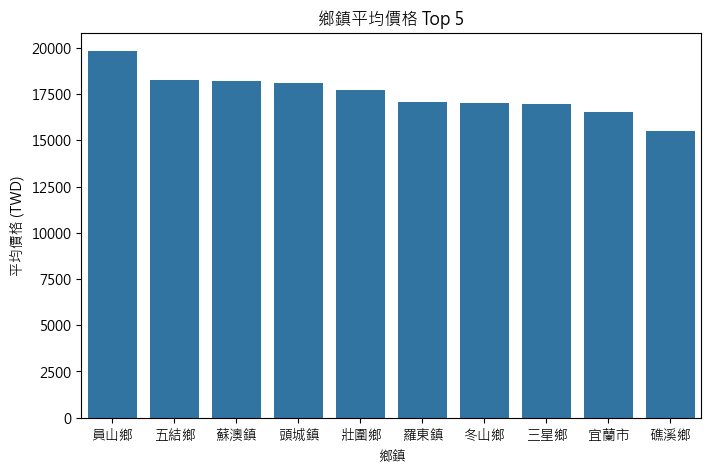

In [19]:
top5_towns = df_filtered.groupby('Town')['price'].mean().sort_values(ascending=False).tail(15)

plt.figure(figsize=(8, 5))
sns.barplot(x=top5_towns.index, y=top5_towns.values)
plt.title('鄉鎮平均價格 Top 5')
plt.ylabel('平均價格 (TWD)')
plt.xlabel('鄉鎮')
plt.show()


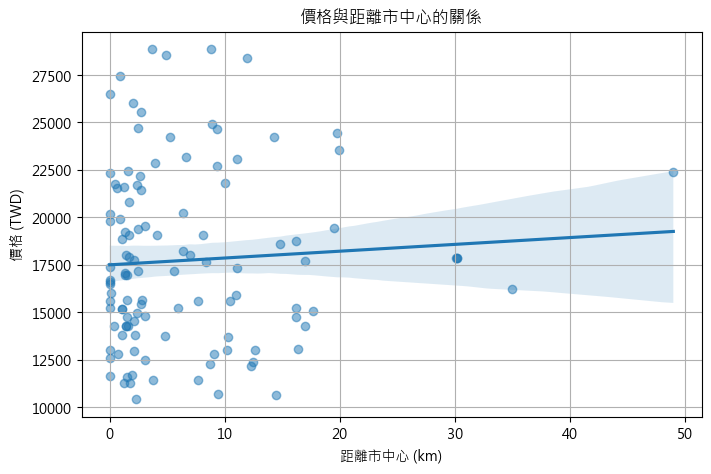

In [20]:
plt.figure(figsize=(8, 5))
sns.regplot(data=df_filtered, x='Distance_from_Central', y='price', scatter_kws={'alpha': 0.5})
plt.title('價格與距離市中心的關係')
plt.xlabel('距離市中心 (km)')
plt.ylabel('價格 (TWD)')
plt.grid(True)
plt.show()


In [21]:
i = 0
listData = []

driver = webdriver.Chrome(options = my_options)
url = 'https://www.agoda.com/'
driver.get(url)
searchLoca('宜蘭')
for i in range (1, 31):
    if i != 30:
        inputInfo(2025, 9, i, 2025, 9, i+1, 1, 10, 0)
    else:
        inputInfo(2025, 9, 30, 2025, 10, 1, 1, 10, 0)
    
    sleep(5)

    # 取得該日期房間總數量
    allNum = driver.find_element(By.CSS_SELECTOR, '#autocomplete-box div.SearchBoxTextDescription__desc')
    availHotel = allNum.get_attribute('innerHTML')
    match = re.match(r"\d+", availHotel)

    if match:
        number = int(match.group())

    listData.append({f'Day {i} 房源數 {number}'})

pprint(listData)

[{'Day 1 房源數 295'},
 {'Day 2 房源數 295'},
 {'Day 3 房源數 293'},
 {'Day 4 房源數 290'},
 {'Day 5 房源數 237'},
 {'Day 6 房源數 278'},
 {'Day 7 房源數 293'},
 {'Day 8 房源數 294'},
 {'Day 9 房源數 293'},
 {'Day 10 房源數 295'},
 {'Day 11 房源數 266'},
 {'Day 12 房源數 230'},
 {'Day 13 房源數 281'},
 {'Day 14 房源數 285'},
 {'Day 15 房源數 285'},
 {'Day 16 房源數 284'},
 {'Day 17 房源數 284'},
 {'Day 18 房源數 274'},
 {'Day 19 房源數 220'},
 {'Day 20 房源數 271'},
 {'Day 21 房源數 269'},
 {'Day 22 房源數 265'},
 {'Day 23 房源數 275'},
 {'Day 24 房源數 278'},
 {'Day 25 房源數 264'},
 {'Day 26 房源數 180'},
 {'Day 27 房源數 234'},
 {'Day 28 房源數 277'},
 {'Day 29 房源數 233'},
 {'Day 30 房源數 0'}]
